In [1]:
## DONE:
# YOU CAN ADD THE SOURCE WHERE IT WAS FETCHED FROM ####?
# NEXT YOU NEED TO FILL `df_template_updated` based on master ds
# cross check with master
# update template to the proper format
# update prompt to reflect changes
# combine all sources together
# define nodes for the graph so it shows master check, ds file check
# refactor the code away from jupyter

## TO DO LIST:

# Setup human in the loop & check how to test it
# Prep a column name swaping so column names are user friendly

# research on how to packege it and expose the endpoint


## SETUP ##

In [2]:
import os
import datetime

from dotenv import load_dotenv
import getpass

from typing import List, TypedDict
from pydantic import BaseModel, Field

from langchain_openai import ChatOpenAI

from langgraph.graph import StateGraph, END
from IPython.display import Image, display

import pandas as pd
from pathlib import Path

import operator
from typing import Annotated
import json

###### INTERNAL MODULES ######
# Config
from rag.config_rag import RAGConfig
# Retrieval RAG
from rag.retriever_formatting import PrepareRetrieval
# helpers
from utils.helpers import template_enricher
# from utils.helpers import df_to_dict
# import docx

In [3]:
# step 0: Setup Secretes
load_dotenv()

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key: ")

# gpt_model = 'gpt-4o-mini'
# gpt_model = 'gpt-5-nano'
gpt_model = 'gpt-4o'

In [4]:
# step 0: setup path and dataset (the same way I get it in future)

### vars
main_dataset = 'datasets/dataset_csv.csv'
master_business_glossary = 'master_business_glossary/master_business_glossary_csv.csv'
master_ds_glossary = 'stewards_and_owners/data_stewards.csv'

basic_path = Path.cwd()
save_temp_results = basic_path / "99_playground"
data_full_path = basic_path / "data/"

##### Get the dataset #####

In [5]:
### Read a dataset & sample from it
df = pd.read_csv(data_full_path / main_dataset, sep=';')
df_sample = df.head(3)
original_sample_dict = df_sample.to_dict(orient='list')
df_sample

,account_id,client_name,street_nm,acct_open_date,prod_code,risk_profile,bal_local,bal_usd,cust_segment,ref_code,tx_code,compliance_flag,internal_score
0,AC100000,Morgan Lopez,1930 Oak Ave,2015-01-13,PC-C,Medium,"1727237,59","1969569,02",SME,AGT0024,T01,Y,"73,05"
1,AC100001,Riley Garcia,7099 Oak Blvd,2017-05-02,EQTY-7,High,"1959629,33","2443069,89",SME,AGT0006,T01,Y,"76,78"
2,AC100002,Morgan Anderson,1412 Pine Rd,2018-03-28,PC-C,Medium,"1077348,73","1137680,26",SME,AGT0031,DIV,N,"62,15"


##### Prepeare the Template based only on the sample #####

In [6]:
## Define what columns we want to have in the final template and separate them depending on what process would fill them in

raw_template_framework = {
    ## Will be taken from the system
    "table_name_value": 'client_account',

    "additional_col": ["Sample Values"],

    ## Will be filled by the Agent
    "search_with_RAG": [
        'Business Domain Name',
        'Business Sub-Domain Name',
        'Business Name',
        'Column Description',
        'Attribute related business rationale',
        'Attribute logical business rules'
    ],
    ## Will be filled from existing file
    "search_with_data_steward_file": [
        'Data Owner Name',
        'Data Owner E-Mail',
        # 'Data Steward Approval',
        # 'Data Steward Feedback (only if not approved)',
        # 'Data Owner Approval',
        # 'Data Owner Feedback (only if not approved)'
    ],
}


to_be_discussed = [
    "Data Steward Approval",
    "Data Steward Feedback (only if not approved)",
    "Data Owner Approval",
    "Data Owner Feedback (only if not approved)"]

##### Read external files #####

In [7]:
# MASTER BUSINESS GLOSSARY
df_bg_glossary = pd.read_csv(data_full_path / master_business_glossary, sep=';')
# drop for now
df_bg_glossary.drop(columns=to_be_discussed, inplace=True)

bg_glossary_dict = df_bg_glossary.to_dict(orient='list')
# bg_glossary_dict

{'Table Name': ['client_account',
  'client_account',
  'client_account',
  'client_account',
  'client_account',
  'client_account',
  'client_account',
  'client_account',
  'client_account',
  'client_account',
  'client_account',
  'client_account',
  'client_account',
  'client_account',
  'client_account',
  'data_manag_table',
  'data_manag_table',
  'risk_monitor',
  'risk_monitor',
  'risk_monitor',
  'risk_monitor',
  'risk_monitor',
  'risk_monitor',
  'risk_monitor'],
 'Column Name': ['account_id',
  'client_name',
  'street_nm',
  'acct_open_date',
  'bal_local',
  'bal_usd',
  'ref_agent_id',
  'product_fee_tier',
  'booking_entity',
  'cust_onboard_channel',
  'account_type',
  'currency_code',
  'last_activity_date',
  'open_issue_count',
  'svc_level',
  'data_source_system',
  'record_last_updated',
  'kyc_status',
  'aml_alert_level',
  'credit_limit',
  'collateral_type',
  'tax_residency',
  'beneficial_owner',
  'reporting_bucket'],
 'Business Domain Name': ['Clie

In [8]:
# MASTER DATA STEWARD
df_ds_master = pd.read_csv(data_full_path /master_ds_glossary, sep=';')
ds_master_dict = df_ds_master.to_dict(orient='list')
# ds_master_dict

{'Table Name': ['client_account',
  'data_manag_table',
  'risk_monitor',
  'dataset_4_transactions',
  'dataset_5_loans',
  'dataset_6_riskscores',
  'dataset_7_portfolio',
  'dataset_8_riskscores',
  'dataset_9_clients',
  'dataset_10_loans',
  'dataset_11_riskscores',
  'dataset_12_portfolio',
  'dataset_13_riskscores',
  'dataset_14_portfolio',
  'dataset_15_portfolio',
  'dataset_16_clients',
  'dataset_17_transactions',
  'dataset_18_trades',
  'dataset_19_riskscores',
  'dataset_20_clients'],
 'Data Steward Name': ['Elena Petra',
  'Ivana Horvat',
  'Elena Petra',
  'Lukas Nowak',
  'Michael Chen',
  'Lukas Nowak',
  'Patricia Gomez',
  'Lukas Nowak',
  'Elena Petra',
  'Lukas Nowak',
  'Lukas Nowak',
  'Michael Chen',
  'Ivana Horvat',
  'Lukas Nowak',
  'Michael Chen',
  'Patricia Gomez',
  'Michael Chen',
  'Adam Kowalski',
  'Adam Kowalski',
  'Sana Iqbal'],
 'Data Steward E-Mail': ['elena.petra@aureliacap.com',
  'ivana.horvat@aureliacap.com',
  'elena.petra@aureliacap.com'

## INITIALIZATION ##

In [9]:
# The structure of a single row in your documentation

class ColumnDef(BaseModel):
    table_name: str = Field(description="The logical or physical name of the database table to which the attribute belongs.")
    column_name: str = Field(description="The exact (physical) name of the column from the source.")
    sample_values: List[str] = Field(default=[], description="Representative example values illustrating valid content and typical usage.")
    business_domain_name: str = Field(description="The high-level business domain representing a major business capability or functional area.")
    business_sub_domain_name: str = Field(description="A more granular grouping based on specific business activities.")
    business_name: str = Field(description="The logical, business-friendly semantic name of the attribute.")
    column_description: str = Field(description="A clear and concise definition of what the data element represents in business terms.")
    business_rationale: str = Field(description="Explanation of why the attribute is required and how it supports processes or regulatory needs.")
    logical_business_rules: str = Field(description="The logical constraints, validations, or conditions that govern usage.")
    data_owner: str = Field(description="The role or individual responsible for the data element's quality and governance.")
    data_owner_email: str = Field(description="Contact information for the data owner overseeing this attribute.")
    extra__add_citation_of_the_hit: str = Field(description="A citation of the hit where the information was found.")
    extra__add_source_explained: str = Field(description="The exact value of source where the definition was created.")

# The final list of definitions
class TemplateOutput(BaseModel):
    columns: List[ColumnDef]

# Define the state class
class AgentState(TypedDict, total=False): # total=False -> allows for only partial update of the state
    framework_def: dict
    source_original_table: dict
    master_business_glossary: dict
    master_data_owner: dict

    RAG_cols_with_samples: dict
    RAG_company_context: str
    entire_table_context: dict
    template_df: dict
    result: List[ColumnDef]
    error_message: str
    iterations: int
    review_history_validator: Annotated[List[str], operator.add]

In [10]:
### Prefill the state
initial_state = {
    "framework_def": raw_template_framework, # <- the dictionary which defines the structure of the template to be filled by the Agent
    "source_original_table": original_sample_dict, # <- original table sampled from the dataset. This is starting point - a table which need to be built business glossary for
    "master_business_glossary": bg_glossary_dict, # <- Source of Truth - existing master business glossary file
    "master_data_owner": ds_master_dict, # <- Source of Truth - existing master data owners/stewards file

    "RAG_cols_with_samples": {}, # <- based on these we perform RAG search, this is dict {column name: sample values} for the columns that still have missing values after cross-checking with master business glossary and master data steward file
    "RAG_company_context": "", # <- the final context built based on the RAG search results, this is a string that will be fed into the generator prompt (JSON formatted)
    "entire_table_context": {}, # <- Full table with all external master data filled along with placeholder, to provide the generator agent with additional context and explaining that <agent> tags need to be filled
    "template_df": {}, # <- this is a placeholder which will be filled with the progressively enriched template (first with master business glossary, then with master data steward file), this is stored as dict for better storage in state, but it can be converted to df on the fly in the nodes. After the entire process of enrichment it will be the same dictionary as "entire_table_context"
    "result": [], # <- stores final results from the Generator Node
    "error_message": "", # <- Stores the error message from the Validator Node if the output was not valid, this will be fed back into the Generator Node to fix the output in the next iteration
    "iterations": 0, # <- counts number of iterations between Generator and Validator
    "review_history_validator": [] # <- Store the history of reviews from the Validator Node, this is a list of strings that will be appended with each review (both failed and passed) to keep track of the feedback and improvements over iterations
}

## BUILDING NODES ##

Node 1

In [11]:
def prepare_template_node(state: AgentState) -> AgentState:
    """1) Prepare the Business Glossary template skeleton from the sampled dataset."""

    print("Fetching the template...")

    # Fetch the Template and built a Framework
    framework_def = state.get("framework_def")
    # Build the Framework
    df_template_v0 = pd.DataFrame(original_sample_dict)
    df_template_v1 = pd.DataFrame({
        "Table Name": raw_template_framework['table_name_value'],
        "Column Name": df_template_v0.columns,
        "Sample Values": [df_template_v0[col].tolist() for col in df_template_v0.columns],
    })

    # fill RAG columns
    for c in framework_def['search_with_RAG']:
        df_template_v1[c] = "<agent>"

    # fill data steward file columns
    for c in framework_def['search_with_data_steward_file']:
        df_template_v1[c] = "<ds_master>"

    # For better storage in state convert to dict
    df_template_v1 = df_template_v1.to_dict(orient='list')

    return {"template_df": df_template_v1}

Node 2

In [12]:
def fill_master_business_glossary_node(state: AgentState) -> AgentState:
    """2) Enrich the template from the Master Business Glossary and keep placeholders for missing fields."""

    # Perform the 1st enrichment using Master Business Glossary file

    print("Cross-checking with Master Business Glossary...")

    # Access the Template for columns which are defined there
    framework_def = state.get("framework_def")

    ## Read newly created template built in Node 1
    df_template = state.get("template_df")
    df_template = pd.DataFrame(df_template)

    ## Read original master business glossary
    bg_glossary = state.get("master_business_glossary")
    df_bg_glossary = pd.DataFrame(bg_glossary)


    if df_template is None:
        raise ValueError("template_df is missing. 'prepare_template_node' must run first.")

    ## Perform 1st enrichment by merging with Master Business Glossary
    fill_cols = framework_def['search_with_RAG'] + framework_def['additional_col']
    df_template_updated = template_enricher(
        template_df=df_template,
        enrich_df=df_bg_glossary,
        join_keys=["Table Name", "Column Name"],
        fill_cols=fill_cols,
    )

    # Convert to dict on the fly for better storage in state
    df_template_updated = df_template_updated.to_dict(orient='list')

    return {"template_df": df_template_updated}

Node 3

In [13]:
def fill_master_data_steward_node_and_rag_filter(state: AgentState) -> AgentState:
    """3) Enrich the template from the Master Data Steward list; prepare state for RAG + LLM."""

    print("Cross-checking with Master Data Owner/Steward File...")

    ######################## PART 1/2 ########################
    # Perform the 2nd enrichment using Master Data Owner/Steward file

    # Access the Template for columns which are defined there
    framework_def = state.get("framework_def")

    ## Read newly updated template built in Node 1 and Enriched in Node 2
    dict_template = state.get("template_df")
    if dict_template is None:
        raise ValueError("template_df is missing. Previous nodes must run first.")
    df_template = pd.DataFrame(dict_template)

    ## Read original master data owner/steward file
    master_data_owners = state.get("master_data_owner")
    df_do_master = pd.DataFrame(master_data_owners)

    ## Perform 2nd enrichment by merging with Master Data Owners/Stewards
    fill_cols = framework_def['search_with_data_steward_file']
    df_template_updated = template_enricher(
        template_df=df_template,
        enrich_df=df_do_master,
        join_keys=["Table Name"],
        fill_cols=fill_cols,
    )
    # Full table context for the generator (as dict)
    full_dict = df_template_updated.to_dict(orient = 'list')


    ######################## PART 2/2 ########################
    ### When full template is ready, filter only those rows which need to be filled in by RAG (keep only rows with placeholders in RAG columns) - this will be used for retrieval and building the context for the generator

    # Restrict RAG to only columns that still contain placeholders (extract rows which contains tag <...>)
    pattern = r"<.*?>"
    df_only_missing_values = df_template_updated[df_template_updated.apply(lambda row: row.astype(str).str.contains(pattern).any(), axis=1)]

    ## Below object will be used to perform RAG searches (column name + sample values, e.g. Account_number: [12345, 67890, 111213])
    dict_for_RAG_search = dict(zip(df_only_missing_values["Column Name"], df_only_missing_values["Sample Values"]))

    return {
        "template_df": full_dict, # in fact doesn't need to be retrieved but returned as updated object for clarity
        "entire_table_context": full_dict,
        "RAG_cols_with_samples": dict_for_RAG_search,
    }

##### Node 4

In [14]:
def rag_retrieval_node(state: AgentState) -> AgentState:
    """4. Perform retrieval and build context prompt"""
    # Get column samples from state
    col_samples = state.get("RAG_cols_with_samples")

    # Get PrepareRetrieval instance
    cfg = RAGConfig(project_root=basic_path)
    prep = PrepareRetrieval(cfg)

    # Retrieve information and build prompt
    results = prep.retrieve_for_all_columns(col_samples)
    company_context_prompt = prep.build_prompt_and_format(results)

    # Update state with context prompt
    return {
        "RAG_company_context": company_context_prompt
    }


##### Node 5

In [15]:
# Initialize the model
llm = ChatOpenAI(model=gpt_model, temperature=0)

In [16]:
structured_llm = llm.with_structured_output(TemplateOutput)

def generator_node(state: AgentState):
    """5. Define the Generator Agent logic"""

    print(f"--- GENERATOR: Filling the template (Attempt {state['iterations'] + 1}) ---")

    full_table_context = json.dumps(state.get('entire_table_context'), indent=2) # Convert dict to JSON on the fly so it's better formatted when supplying to the Agent
    rag_company_context = (state.get('RAG_company_context', "No additional context provided."))


    prompt = f"""
    ### ROLE
    You are an expert Data Steward specializing in Enterprise Data Governance. Your task is to populate a Business Glossary with high-accuracy metadata and to return the **COMPLETE** Business Glossary table!

    ### INPUT DATA
    1. **TARGET_TABLE**: Contains current metadata. Fields marked `<agent>` must be populated. Fields with existing text are "Source of Truth" and must be used as guidance/context for the missing fields.
       {full_table_context}

    2. **COMPANY_CONTEXT (RAG)**: A JSON collection of 'hits' containing 'text' and 'source'. Use this as your primary evidence.
       {rag_company_context}

    ### EXTRACTION RULES & LOGIC
    For every field marked `<agent>`, apply the following logic:

    * **Source Priority**:
        1. Primary: Use **COMPANY_CONTEXT (RAG)**.
        2. Secondary: If RAG is silent, infer meaning from the **TARGET_TABLE** (existing descriptions of related columns or sample values).
        3. Tertiary: Use your internal expertise to provide the most likely business definition.
    * **Semantic Transformation (`business_name`)**: Convert technical column names (e.g., `CUST_ID_01`) into logical, Title Case names (e.g., `Customer Identifier`). Expand all abbreviations.
    * **Business Definition (`column_description`)**: Provide a functional definition. Focus on business value; do not refer to technical data types.
    * **Evidence Handling**:
        * `extra__add_citation_of_the_hit`: Three possible values can be placed here: 1) If using RAG, extract the verbatim sentence. 2) If the fields was already filled, say: "Master Business Glossary". 3) If none of the previous and Agent invented it with no source, say "Agent Logic".
        * `extra__add_source_explained`: Three possible values can be placed here: 1) If using RAG, provide the exact 'source' value. 2) If the fields was already filled, say: "Master Business Glossary". 3) If none of the previous and Agent invented it with no source, say "Agent Logic".
    * **Fallback Protocol**: If absolutely no information can be found or reasonably inferred, you must set:
        * `extra__add_citation_of_the_hit`: "No relevant context found; best effort estimation."
        * `extra__add_source_explained`: "Agent Knowledge"

    ### CONSTRAINTS
    - Your goal is to fill the table as much as possible. Do not leave fields blank if a reasonable business inference can be made from the column name or samples.
    - DO NOT modify any values in the table that are NOT marked with `<agent>`.
    - Ensure `business_sub_domain_name` is a specific subset of `business_domain_name`.
    - Maintain professional, neutral language.

    ### RECONSTRUCTION RULE
    - For fields that were **already filled** in the input: Copy them exactly into your response.
    - For fields marked `<agent>`: Replace the tag with your generated metadata.
    - The number of objects in your output `result` list must exactly match the number of columns in the input.
    """

    # If the Critic left feedback, add it to the prompt
    if state['error_message'] and state['error_message'] != "none":
        prompt += f"\n\nCRITIC FEEDBACK FROM PREVIOUS ATTEMPT:\n{state['error_message']}\nPlease fix these issues."

    response = structured_llm.invoke(prompt)
    return {
        "result": response.columns,
        "iterations": state['iterations'] + 1
    }

##### Node 6

In [17]:
class ValidationResult(BaseModel):
    is_valid: bool = Field(description="True if all definitions are sensible and all columns are present.")
    feedback: str = Field(description="If is_valid is False, provide specific instructions on what to fix.")

# A separate structured LLM for the critic
critic_llm = llm.with_structured_output(ValidationResult)

def validator_node(state: AgentState):
    """6. Define the Validator Agent logic"""

    print("--- CRITIC: Reviewing... ---")

    # Calculate counts to check for data loss
    input_table = state.get('entire_table_context', {})
    expected_count = len(input_table.get('Column Name', []))
    actual_count = len(state['result'])

    current_work = "\n".join([
        f"Column: {c.column_name}\n"
        f"Proposed Description: {c.column_description}\n"
        f"Source Used: {c.extra__add_source_explained}\n"
        f"Evidence/Logic: {c.extra__add_citation_of_the_hit}\n"
        "---"
        for c in state['result']
    ])

    rag_company_context = state.get('RAG_company_context', "No additional context provided.")
    full_table_context = state.get('entire_table_context', {})

    # 2. Refined Critic Prompt
    critic_prompt = f"""
    ### ROLE
    You are a Senior Data Governance Auditor. Your task is to validate the accuracy and logic of a Business Glossary.

    ### CONTEXT
    PRIMARY EVIDENCE (RAG): {rag_company_context}
    SECONDARY CONTEXT (Full Table/Samples): {full_table_context}

    ### WORK TO REVIEW
    {current_work}

    ### VALIDATION RULES
    1. **Check RAG Consistency**: If 'Source Used' is a document name, verify the 'Proposed Description' matches the facts in the PRIMARY EVIDENCE.
    2. **Check Inference Logic**: If 'Source Used' is 'Agent Logic', verify if the description is a reasonable "smart guess" based on the Column Name and Table Context.
       *Example: If column is 'strt' and contains 'Washington St', the definition should be about Address/Location.*
    3. **Quality Check**:
       - Ensure no technical jargon (like 'VARCHAR' or 'NULL') is in the description.
       - Ensure the Generator provided a source. If it says "Agent Knowledge" when the info was clearly in the RAG, flag this.

    ### OUTPUT
    1. Evaluate if the definitions are sensible. If any description is misleading, or if the agent ignored the provided RAG context, set is_valid = False and provide specific feedback for those columns.
    2. Make sure the number of EXPECTED COLUMNS ({expected_count}) match the ACTUAL COLUMNS RETURNED ({actual_count}). If ACTUAL does not match EXPECTED, set is_valid = False and state "Missing columns in output".
    3. Makre sure non of the rows were left empty. All have to be filled in. If any row is empty, set is_valid = False and state "Empty definition for row Y column X".
    """

    review = critic_llm.invoke(critic_prompt)

    if not review.is_valid:
        print(f"--- CRITIC FEEDBACK: {review.feedback} ---")
        return {
            "error_message": review.feedback,
            "review_history_validator": [f"Step {state['iterations']} Critic: {review.feedback}"]
        }

    return {
        "error_message": "none",
        "review_history_validator": [f"Critique (Passed): {review.feedback}"]
    }

##### Compile Nodes

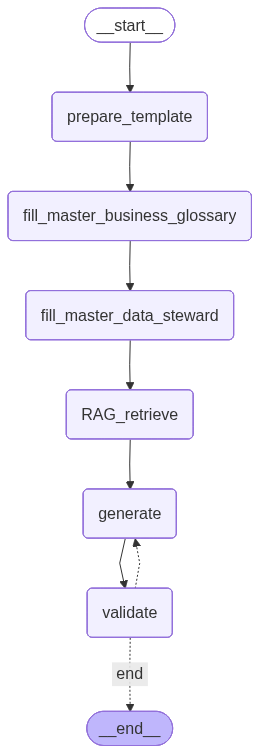

In [18]:
def router(state: AgentState):
    if state["error_message"] == "none":
        return "end"
    if state["iterations"] >= 3:
        print("!!! Max attempts reached. Ending with current result.")
        return "end"
    return "generate"

# Define Nodes
workflow = StateGraph(AgentState)

# Pre-processing Nodes
workflow.add_node("prepare_template", prepare_template_node)
workflow.add_node("fill_master_business_glossary", fill_master_business_glossary_node)
workflow.add_node("fill_master_data_steward", fill_master_data_steward_node_and_rag_filter)
workflow.add_node("RAG_retrieve", rag_retrieval_node)
# Agentic Nodes
workflow.add_node("generate", generator_node)
workflow.add_node("validate", validator_node)

workflow.set_entry_point("prepare_template")

# Define the Flow
workflow.add_edge("prepare_template", "fill_master_business_glossary")
workflow.add_edge("fill_master_business_glossary", "fill_master_data_steward")
workflow.add_edge("fill_master_data_steward", "RAG_retrieve")

workflow.add_edge("RAG_retrieve", "generate")
workflow.add_edge("generate", "validate")

workflow.add_conditional_edges(
    "validate",
    router,
    {
        "generate": "generate",
        "end": END
    }
)

# Compile
app = workflow.compile()

# Visualize the new 2-node structure
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Graph compilation failed:", str(e))

##### Invoke Agent

In [19]:
# Run the app
config = {"recursion_limit": 10}
final_output = app.invoke(initial_state, config)

# Extract
df = pd.DataFrame([c.model_dump() for c in final_output['result']])

# Save
datestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
df.to_csv(save_temp_results / f'BG_TEST_v1_{datestamp}.csv', index=False, sep=";")
print("\n" + ".CSV has been saved!")

# Display the final 'Template'
print("\n" + "="*30)
print("FINAL PREFILLED TEMPLATE")
print("="*30)
df

Fetching the template...
Cross-checking with Master Business Glossary...
Cross-checking with Master Data Owner/Steward File...
Loading vector database from C:\Users\marcin.grzechowiak\Desktop\repos_learn\05_agent_dmo\business_glossary\vector_dbs\chroma_db...
✓ Loaded database with 88 chunks
Retrieving 1 chunk(s) for query: 'Find relevant information for the following variable: Column Name: 'prod_code'. Example Values: PC-C, EQTY-7, PC-C. '
✓ Retrieved 1 chunk(s)
Retrieving 1 chunk(s) for query: 'Find relevant information for the following variable: Column Name: 'risk_profile'. Example Values: Medium, High, Medium. '
✓ Retrieved 1 chunk(s)
Retrieving 1 chunk(s) for query: 'Find relevant information for the following variable: Column Name: 'cust_segment'. Example Values: SME, SME, SME. '
✓ Retrieved 1 chunk(s)
Retrieving 1 chunk(s) for query: 'Find relevant information for the following variable: Column Name: 'ref_code'. Example Values: AGT0024, AGT0006, AGT0031. '
✓ Retrieved 1 chunk(s)

,table_name,column_name,sample_values,business_domain_name,business_sub_domain_name,business_name,column_description,business_rationale,logical_business_rules,data_owner,data_owner_email,extra__add_citation_of_the_hit,extra__add_source_explained
0,client_account,account_id,[ACC123456789],Client & Account Management,Account Master Data,Client Account Identifier,Unique identifier for a client account within ...,Enables unique identification and traceability...,Mandatory; unique; immutable once assigned,Victor Vance,victor.vance@aureliacap.com,Master Business Glossary,Master Business Glossary
1,client_account,client_name,[ABC Holdings Ltd],Client & Account Management,Client Identity,Client Legal Name,Full legal name of the client as captured duri...,"Required for legal identification, contracts, ...",Mandatory; must match onboarding legal documen...,Victor Vance,victor.vance@aureliacap.com,Master Business Glossary,Master Business Glossary
2,client_account,street_nm,[12 Baker Street],Client & Account Management,Client Address,Client Street Address,Primary mailing address field from onboarding;...,"Supports correspondence, jurisdiction checks, ...",Optional; free text,Victor Vance,victor.vance@aureliacap.com,Master Business Glossary,Master Business Glossary
3,client_account,acct_open_date,[15.03.2022],Client & Account Management,Account Lifecycle,Account Opening Date,Date when the account was officially opened in...,"Determines account age, lifecycle stage, and r...",Mandatory; must be <= current date,Victor Vance,victor.vance@aureliacap.com,Master Business Glossary,Master Business Glossary
4,client_account,prod_code,"[PC-C, EQTY-7, PC-C]",Product Management,Product Identification,Product Code,Business product shortcodes used by Sales and ...,Facilitates product identification and categor...,Mandatory; must match predefined product codes,Victor Vance,victor.vance@aureliacap.com,Key information: If there is a name such as p...,C:\Users\marcin.grzechowiak\Desktop\repos_lear...
5,client_account,risk_profile,"[Medium, High, Medium]",Risk Management,Risk Assessment,Risk Profile,Classification of client accounts based on exp...,Supports risk assessment and management strate...,Categorical; must align with risk assessment c...,Victor Vance,victor.vance@aureliacap.com,"In portfolio data, HNI accounts often exhibit ...",C:\Users\marcin.grzechowiak\Desktop\repos_lear...
6,client_account,bal_local,[125000.50],Finance,Account Balances,Local Currency Account Balance,Account balance in the client's local reportin...,"Used for client reporting, interest calculatio...",Numeric; may be negative,Victor Vance,victor.vance@aureliacap.com,Master Business Glossary,Master Business Glossary
7,client_account,bal_usd,[137500.75],Finance,Account Balances,USD Equivalent Account Balance,Account balance converted to USD using interna...,Enables consolidated financial and risk report...,Derived using approved FX rates,Victor Vance,victor.vance@aureliacap.com,Master Business Glossary,Master Business Glossary
8,client_account,cust_segment,"[SME, SME, SME]",Client & Account Management,Client Segmentation,Customer Segment,Classifies clients into high-level commercial ...,"Reflects differences in client size, regulator...",Categorical; must align with segmentation crit...,Victor Vance,victor.vance@aureliacap.com,The cust_segment field classifies clients into...,C:\Users\marcin.grzechowiak\Desktop\repos_lear...
9,client_account,ref_code,"[AGT0024, AGT0006, AGT0031]",Human Resources,Agent Identification,Reference Code,Internal employee/agent identifier. The last d...,Facilitates identification and classification ...,Mandatory; must follow AGT prefix format,Victor Vance,victor.vance@aureliacap.com,`ref_code` refers to internal employee/agent i...,C:\Users\marcin.grzechowiak\Desktop\repos_lear...


##### Check logs #####

In [28]:
pd.DataFrame((final_output['entire_table_context']))

,Table Name,Column Name,Sample Values,Business Domain Name,Business Sub-Domain Name,Business Name,Column Description,Attribute related business rationale,Attribute logical business rules,Data Owner Name,Data Owner E-Mail
0,client_account,account_id,ACC123456789,Client & Account Management,Account Master Data,Client Account Identifier,Unique identifier for a client account within ...,Enables unique identification and traceability...,Mandatory; unique; immutable once assigned,Victor Vance,victor.vance@aureliacap.com
1,client_account,client_name,ABC Holdings Ltd,Client & Account Management,Client Identity,Client Legal Name,Full legal name of the client as captured duri...,"Required for legal identification, contracts, ...",Mandatory; must match onboarding legal documen...,Victor Vance,victor.vance@aureliacap.com
2,client_account,street_nm,12 Baker Street,Client & Account Management,Client Address,Client Street Address,Primary mailing address field from onboarding;...,"Supports correspondence, jurisdiction checks, ...",Optional; free text,Victor Vance,victor.vance@aureliacap.com
3,client_account,acct_open_date,15.03.2022,Client & Account Management,Account Lifecycle,Account Opening Date,Date when the account was officially opened in...,"Determines account age, lifecycle stage, and r...",Mandatory; must be <= current date,Victor Vance,victor.vance@aureliacap.com
4,client_account,prod_code,"[PC-C, EQTY-7, PC-C]",<agent>,<agent>,<agent>,<agent>,<agent>,<agent>,Victor Vance,victor.vance@aureliacap.com
5,client_account,risk_profile,"[Medium, High, Medium]",<agent>,<agent>,<agent>,<agent>,<agent>,<agent>,Victor Vance,victor.vance@aureliacap.com
6,client_account,bal_local,125000.50,Finance,Account Balances,Local Currency Account Balance,Account balance in the client's local reportin...,"Used for client reporting, interest calculatio...",Numeric; may be negative,Victor Vance,victor.vance@aureliacap.com
7,client_account,bal_usd,137500.75,Finance,Account Balances,USD Equivalent Account Balance,Account balance converted to USD using interna...,Enables consolidated financial and risk report...,Derived using approved FX rates,Victor Vance,victor.vance@aureliacap.com
8,client_account,cust_segment,"[SME, SME, SME]",<agent>,<agent>,<agent>,<agent>,<agent>,<agent>,Victor Vance,victor.vance@aureliacap.com
9,client_account,ref_code,"[AGT0024, AGT0006, AGT0031]",<agent>,<agent>,<agent>,<agent>,<agent>,<agent>,Victor Vance,victor.vance@aureliacap.com


In [21]:
# print("\nReview History Log:")
# for log in final_output['review_history_validator']: print(f"- {log}")

In [22]:
# print(final_output['RAG_company_context'])

In [23]:
# print(final_output['entire_table_context'])

In [3]:
# from openai import OpenAI
#
# client = OpenAI(api_key="")
#
# response = client.chat.completions.create(
#     model="gpt-4o",
#     messages=[{"role": "user", "content": "Say hello!"}]
# )
#
# print(response.choices[0].message.content)

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}